## CNN that predicts angle

A simple CNN with one output - a number represents angle of rotation. 

We use this angle to rotate picture back. As a visual indicator of rotation we use drawn rectangles.

In [1]:
import cv2
import random
import pandas as pd
import matplotlib.image as mpimg
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import load_model
from keras.models import Sequential
from keras.layers import Lambda, Dense, Flatten, Dropout
from keras.layers import Conv2D, Activation, ELU
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# constants
SIZE = 64
BATCH_SIZE = 64

In [3]:
# read csv logs
rows = pd.read_csv('datalog_train.csv')
angles = rows['angle'].tolist()
cos = rows['cos'].tolist()
sin = rows['sin'].tolist()
samples = rows['image'].tolist()
print("Number of training samples: ", len(angles))

Number of training samples:  11000


In [4]:
# encode angles as cos, sin pair and check correctness
cossin = [[cos[i], sin[i]] for i in range(len(angles))]
print("Check num of samples: ", len(cossin))
print("Calculate angle using arctan2: ", np.arctan2(cossin[0][1], cossin[0][0]) * 180 / np.pi)
print("Actual angle: ", angles[0])

Check num of samples:  11000
Calculate angle using arctan2:  10.0
Actual angle:  10.0


In [5]:
# split
shuffle(samples, cossin)
imgs_train, imgs_valid, angles_train, angles_valid = train_test_split(samples, cossin, test_size=0.3)

In [6]:
# data preprocessing pipeline
def resize(img):
    return cv2.resize(img, (SIZE, SIZE))

def random_shift(img):
    if random.randint(0, 1) == 0:
        return img
    h, w, c = img.shape
    shape = (w, h)
    M = np.float32([[1, 0, random.randint(-SIZE // 7, SIZE // 7)],
                    [0, 1, random.randint(-SIZE // 9, SIZE // 9)]])
    return cv2.warpAffine(img, M, shape)

def random_rotation(img):
    if random.randint(0, 1) == 0:
        return img
    angle = random.uniform(-5, 5)
    height, width, ch = img.shape
    shape = (width, height)
    center = (width // 2, height // 2)
    M = cv2.getRotationMatrix2D(center,angle,1.0)
    return cv2.warpAffine(img, M, shape)

def random_shadow(img):
    if random.randint(0, 1) == 0:
        return img
    # set top x
    x_top = random.randint(0, img.shape[1])
    # set bottom x
    x_bot = random.randint(0, img.shape[1])
    if x_top >= img.shape[1] // 2:
        x_bot = random.randint(0, img.shape[1] // 2)
    if x_top > img.shape[1] // 2:
        x_bot = random.randint(img.shape[1] // 2, img.shape[1])
    # set corner x
    x3 = x4 = random.choice([0, img.shape[1]])
    # set y1, y2
    y1 = 0
    y2 = img.shape[0]
    # draw shadow
    overlay = np.copy(img)
    pts = np.array([[x_top, y1], [x3, y1], [x4, y2], [x_bot, y2]], np.int32)
    shadow = cv2.fillPoly(overlay, [pts], (0, 0, 0))
    alfa = random.uniform(0.2, 0.8)
    return cv2.addWeighted(shadow, alfa, img, 1 - alfa, 0)

In [7]:
# generators
def train_generator(batch_size):
    while True:  # Loop forever so the generator never terminates
        shuffle(imgs_train, angles_train)
        batch_imgs = []
        batch_angles = []
        for i in range(batch_size):
            random_index = random.randint(0,len(imgs_train)-1)
            angle = angles_train[random_index]
            angle[0] = angle[0] * (1 + random.uniform(-0.05, 0.05)) # add noise
            angle[1] = angle[1] * (1 + random.uniform(-0.05, 0.05)) # add noise
            img = mpimg.imread(imgs_train[random_index])
            img = random_shift(img)
            img = random_shadow(img)
            img = random_rotation(img)
            img = resize(img)
            batch_imgs.append(img)
            batch_angles.append(angle)
        yield (np.array(batch_imgs), np.array(batch_angles))


def valid_generator(batch_size):
    while True:  # Loop forever so the generator never terminates
        shuffle(imgs_valid, angles_valid)
        batch_imgs = []
        batch_angles = []
        for i in range(batch_size):
            random_index = random.randint(0,len(imgs_valid)-1)
            angle = angles_valid[random_index]
            img = mpimg.imread(imgs_valid[random_index])
            img = resize(img)
            batch_imgs.append(img)
            batch_angles.append(angle)
        yield (np.array(batch_imgs), np.array(batch_angles))

# generate
generator_train = train_generator(BATCH_SIZE)
generator_valid = valid_generator(BATCH_SIZE)

In [8]:
# parameters
steps_per_epoch = len(imgs_train) // BATCH_SIZE
val_steps = len(imgs_valid) // BATCH_SIZE
shape = (SIZE, SIZE, 3)

In [9]:
# network architecture
def guess_angle():
    model = Sequential()
    model.add(Lambda(lambda x: (x / 250) - 0.5, input_shape=shape))

    model.add(Conv2D(24, (5, 5), strides=(2, 2), padding="valid", 
                     kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation('tanh'))
    
    model.add(Conv2D(36, (5, 5), strides=(2, 2), padding="valid", 
                     kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation('tanh'))
    
    model.add(Conv2D(48, (5, 5), strides=(2, 2), padding="valid", 
                     kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation('tanh'))
    
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding="valid", 
                     kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation('tanh'))
    
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding="valid", 
                     kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.001)))
    model.add(Activation('tanh'))
    
    model.add(Flatten())

    model.add(Dense(100, kernel_initializer='he_normal'))
    model.add(Activation('tanh'))
    model.add(Dropout(0.7))
    
    model.add(Dense(50, kernel_initializer='he_normal'))
    model.add(Activation('tanh'))
    model.add(Dropout(0.7))
    
    model.add(Dense(10, kernel_initializer='he_normal'))
    model.add(Activation('tanh'))
    model.add(Dropout(0.4))
    
    model.add(Dense(2))
    return model

In [10]:
model = guess_angle()

# train and save
adam = Adam(lr=0.005)

import keras.backend as K
def scheduler(epoch):
    if epoch == 0:
        print("learning rate:", K.get_value(model.optimizer.lr))
    if (epoch+1) % 10 == 0:
        rate = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, rate * 0.3)
        print("learning rate:", K.get_value(model.optimizer.lr))
    return K.get_value(model.optimizer.lr)


learning_rate_decay = LearningRateScheduler(scheduler)
early_stop = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint('model_cossin.h5', monitor='val_loss', save_best_only=True)

model.compile(loss='mse', optimizer=adam)
model.summary()

history = model.fit_generator(generator_train,
                    steps_per_epoch=steps_per_epoch,
                    epochs=20,
                    validation_data=generator_valid,
                    validation_steps=val_steps, 
                    callbacks=[checkpoint, early_stop, learning_rate_decay])

model.save('model_cossin.h5')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 24)        1824      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 36)        21636     
_________________________________________________________________
activation_2 (Activation)    (None, 13, 13, 36)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 48)          43248     
_________________________________________________________________
activation_3 (Activation)    (None, 5, 5, 48)          0         
__________

## Evaluate model

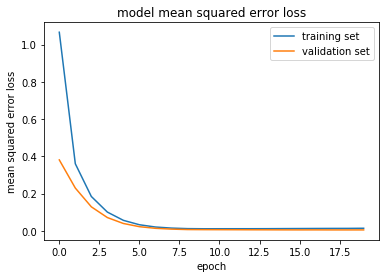

In [11]:
# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [12]:
# read csv logs
rows_test = pd.read_csv('datalog_test.csv')
angles_test = rows_test['angle'].tolist()
cos_test = rows_test['cos'].tolist()
sin_test = rows_test['sin'].tolist()
samples_test = rows_test['image'].tolist()
print("Number of test samples: ", len(samples_test))

Number of test samples:  1000


In [13]:
# evaluate on test data
cossin_test = [[cos_test[i], sin_test[i]] for i in range(len(angles_test))]
img_test = []
ang_test = []

for i in range(len(samples_test)):
    angle = cossin_test[i]
    img = mpimg.imread(samples_test[i])
    img = resize(img)
    img_test.append(img)
    ang_test.append(angle)
    
score = model.evaluate(np.array(img_test), np.array(ang_test), verbose=0)
print("Average error: ±{0:.2f}".format(np.sqrt(score)))

Average error: ±0.07


Actual angle:  -7.3
Actual cos, sin:  0.9918944425900296 -0.12706460860135044
Angle calculated:  -7.3


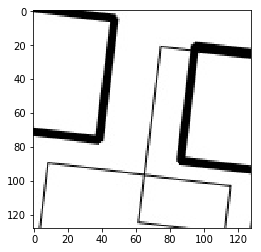

In [15]:
# example: one test image that we want to correct
random.seed(10)
random_index = random.randint(0,len(samples_test)-1)
angle = angles_test[random_index]
img = mpimg.imread(samples_test[random_index])
plt.imshow(img)
print("Actual angle: ", angle)
print("Actual cos, sin: ", cossin_test[random_index][0], cossin_test[random_index][1])
# check that if sin/cos predicted correctly we get right answer
print("Angle calculated: ", np.arctan2(cossin_test[random_index][1], cossin_test[random_index][0]) * 180 / np.pi)

In [16]:
# predict angle
image = np.copy(img)
image = resize(image)
image_array = np.asarray(image)
cs = model.predict(image_array[None, :, :, :], batch_size=1)
ang = np.arctan2(cs[0][1], cs[0][0]) * 180 / np.pi
print("Predicted angle: ", ang)
print("Predicted cos, sin: ", cs[0][0], cs[0][1])

Predicted angle:  -0.24335603827
Predicted cos, sin:  0.996518 -0.0042326


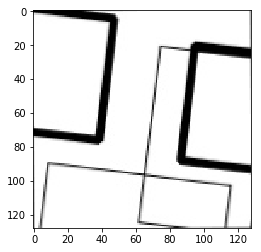

In [17]:
# angle correction
height, width, ch = img.shape
sh = (width, height)
center = (width // 2, height // 2)
M = cv2.getRotationMatrix2D(center, -ang, 1.0)
result = cv2.warpAffine(img, M, sh)
plt.imshow(result)
plt.show()

Number of samples:    1000
Shape of the images:  (128, 128, 3)


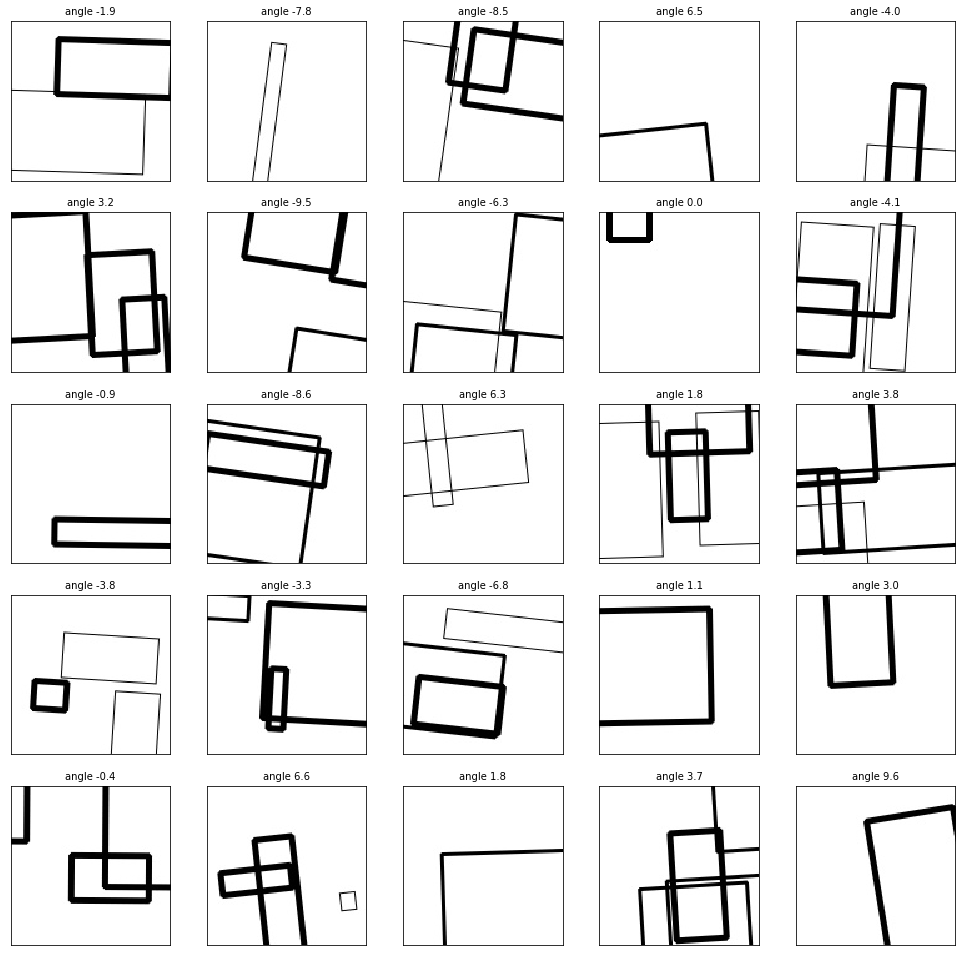

In [18]:
random.seed(42)

# load samples
rows_test = pd.read_csv('datalog_test.csv')
angles_test = rows_test['angle'].tolist()
cos_test = rows_test['cos'].tolist()
sin_test = rows_test['sin'].tolist()
samples_test = rows_test['image'].tolist()

cossin_test = [[cos_test[i], sin_test[i]] for i in range(len(angles_test))]

img_test = []
ang_test = []

for i in range(len(samples_test)):
    angle = angles_test[i]
    img = mpimg.imread(samples_test[i])
    img_test.append(img)
    ang_test.append(angle)
    
print("Number of samples:   ", len(img_test))
print("Shape of the images: ", img_test[0].shape)

n_rows = 5
n_cols = 5
plt.figure(figsize=(17, 17))

indx_rand = []
# print random images we want to fix
for i in range(n_rows*n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    # random index
    index = random.randint(0, len(img_test)-1)
    image = img_test[index]
    angle = angles_test[index]
    indx_rand.append(index)
    plt.title('angle ' + str(angle), fontsize=10)
    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
    plt.imshow(image)

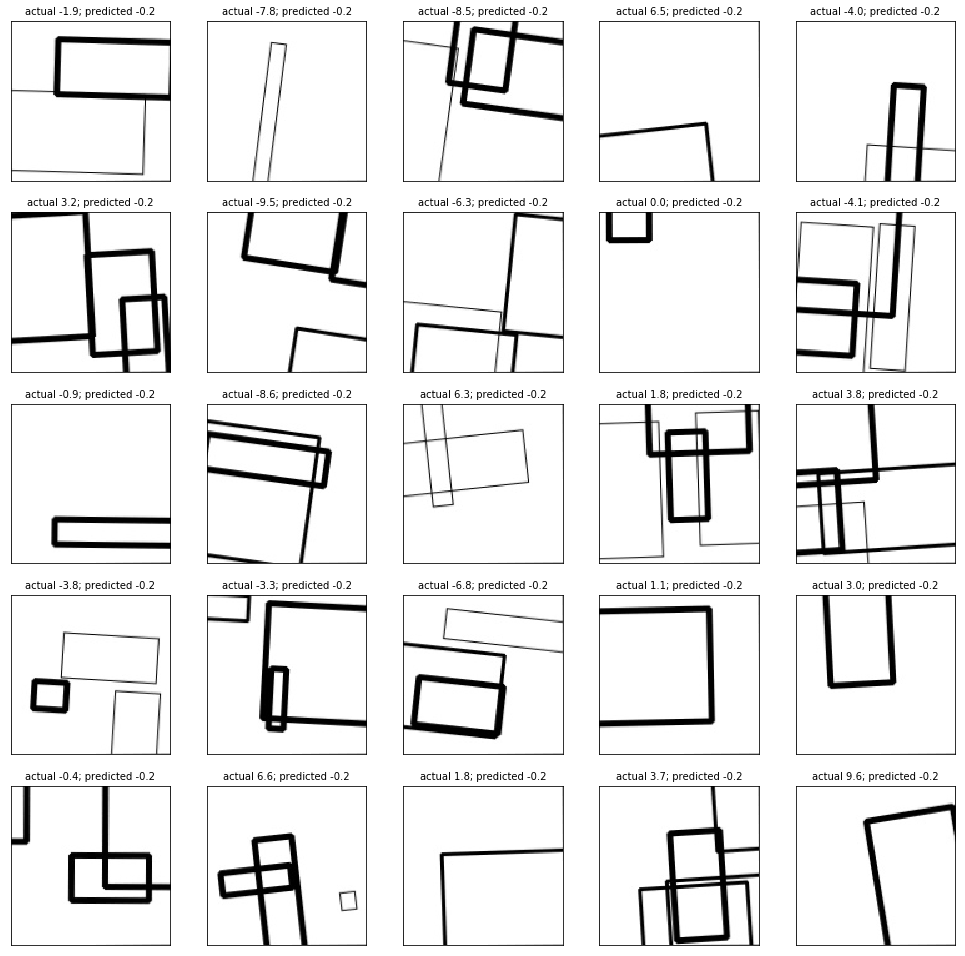

In [19]:
# angle correction
def rotate(img, ang):
    height, width, ch = img.shape
    sh = (width, height)
    center = (width // 2, height // 2)
    M = cv2.getRotationMatrix2D(center, ang, 1.0)
    return cv2.warpAffine(img, M, sh)

n_rows = 5
n_cols = 5
plt.figure(figsize=(17, 17))

# print corrected images
for i in range(n_rows*n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    image = img_test[indx_rand[i]]
    # predict angle
    img_t = np.copy(image)
    img_t = resize(img_t)
    image_array = np.asarray(img_t)
    cs = model.predict(image_array[None, :, :, :], batch_size=1)
    angle = np.arctan2(cs[0][1], cs[0][0]) * 180 / np.pi
    # correct rotation
    image = rotate(image, -angle)
    # plot image
    plt.title('actual {}; predicted {}'.format(angles_test[indx_rand[i]], round(angle,1)), fontsize=10)
    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
    plt.imshow(image)